# Photontorch MNIST

A custom recurrent neural network based on photonic components

## Imports

In [1]:
# standard library
import re
import os
import gzip
from urllib.request import urlretrieve

# photontorch
import torch
import photontorch
from photontorch import Component, Network, ClementsNxN, Environment, Mmi, Source, Detector, set_environment
print(photontorch.__file__)

# other
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# set seeds
torch.manual_seed(5)
np.random.seed(1)

# folder to save checkpoints:
CHECKPOINTFOLDER = 'mnist_checkpoints/eunn_photontorch_capacity2'
set_environment(frequency_domain=True, enable_grad=True)

# mpl style context manager
custom_style = lambda : plt.style.context(os.path.abspath('custom.mplstyle'))

/home/flaport/Python/Photontorch/photontorch/__init__.py


## Fetch MNIST Function

In [2]:
def fetch_mnist(redownload=False, verbose=True):
    ''' Get MNIST data in npy format

    Args:
        redownload=False (bool): force redownload, even if file already exists
    '''
    # check if data is already downloaded. If so, do not download again, except
    # when explicitly asked to do so
    if (os.path.exists('mnist_data/train.npy')
        and os.path.exists('mnist_data/test.npy')
        and not redownload):
        # load files from data folder
        return np.load('mnist_data/train.npy'), np.load('mnist_data/test.npy')

    # create folders
    if not os.path.isdir('mnist_data'):
        os.mkdir('mnist_data')

    # check if data is already downloaded. If so, do not download again, except
    # when explicitly asked to do so
    if not (os.path.exists('mnist_data/train_images.gz')
        and os.path.exists('mnist_data/train_labels.gz')
        and os.path.exists('mnist_data/test_images.gz')
        and os.path.exists('mnist_data/test_labels.gz')
        and not redownload):
        if verbose:
            print('downloading mnist data from http://yann.lecun.com/')
        # download data
        urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'mnist_data/train_images.gz')
        urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'mnist_data/train_labels.gz')
        urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 'mnist_data/test_images.gz')
        urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 'mnist_data/test_labels.gz')

    # fill numpy arrays:
    train = np.empty((60000,785), dtype='uint8')
    test = np.empty((10000,785), dtype='uint8')
    
    if verbose:
        print('converting .gz data to .npy')

    for type, npdata in [('train', train),('test', test)]:
        # open the files
        with gzip.open('mnist_data/%s_images.gz'%type, 'rb') as data,\
             gzip.open('mnist_data/%s_labels.gz'%type, 'rb') as labels:

            # skip the first bytes with metadata of the ubyte file:
            data.read(16)
            labels.read(8)

            # read each byte of the gzip file and save it as a uint8 number
            # in the numpy array.
            for i in range(npdata.shape[0]):
                npdata[i,0] = ord(labels.read(1))
                for j in range(784): # append the data after the label
                    npdata[i, j+1] = ord(data.read(1))

    # save numpy arrays
    np.save('mnist_data/train.npy', train)
    np.save('mnist_data/test.npy', test)
    
    if verbose:
        print('finished conversion.')

    return train, test

## EUNN

In [3]:
class EUNN(ClementsNxN):
    def __init__(self, hidden_size, capacity=None):
        """ EUNN __init__

        Args:
            hidden_size (int): the size of the unitary matrix this cell represents.
            capacity (int): 0 < capacity <= hidden_size. This number represents the
                number of layers containing unitary rotations. The higher the capacity,
                the more of the unitary matrix space can be filled. This obviously
                introduces a speed penalty. In recurrent neural networks, a small
                capacity is usually preferred.
        """
        self.hidden_size = int(hidden_size)
        self.capacity = int(hidden_size) if capacity is None else int(capacity)
        super(EUNN, self).__init__(N=self.hidden_size, capacity=self.capacity)
    
    def terminate(self):
        ret = super(EUNN, self).terminate()
        ret.__class__ = self.__class__ # little hack to keep custom forward function
        return ret
    
    def forward(self, x):
        ''' x.shape = (#batches, #features, 2=(real_imag)) 
        
        Note:
            this forward method is only valid if no delays are present
            in the EUNN
        '''
        assert torch.is_tensor(x)
        num_batches, num_features, _ = x.shape
        x = torch.cat([x, torch.zeros((num_batches, self.nmc-num_features, 2), device=self.device)], 1)
        rx, ix = x.permute(2,1,0)[:,None,:,:] # rx.shape = (1, #mc nodes, #batches)
        rx, ix = self._rC.bmm(rx) - self._iC.bmm(ix), self._rC.bmm(ix) + self._iC.bmm(rx)
        det = torch.stack([
            rx[0, -self.num_detectors:, :],
            ix[0, -self.num_detectors:, :],
        ], 0) # det.shape = (2, # detectors, # batches)
        return det.permute(2,1,0)
    
class ModReLU(torch.nn.Module):
    """ A modular ReLU activation function for complex-valued tensors """

    def __init__(self, size):
        super(ModReLU, self).__init__()
        self.bias = torch.nn.Parameter(torch.rand(1, size))
        self.relu = torch.nn.ReLU()

    def forward(self, x, eps=1e-5):
        """ ModReLU forward

        Args:
            x (torch.tensor): A torch float tensor with the real and imaginary part
                stored in the last dimension of the tensor; i.e. x.shape = [a, ...,b, 2]
        Kwargs:
            eps (float): A small number added to the norm of the complex tensor for
                numerical stability.
        """
        x_re, x_im = x[..., 0], x[..., 1]
        norm = torch.sqrt(x_re ** 2 + x_im ** 2) + 1e-5
        phase_re, phase_im = x_re / norm, x_im / norm
        activated_norm = self.relu(norm + self.bias)
        modrelu = torch.stack(
            [activated_norm * phase_re, activated_norm * phase_im], -1
        )
        return modrelu


class EURNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, capacity=2):
        super(EURNN, self).__init__()
        
        self.hidden_size = int(hidden_size)
        self.input_layer = torch.nn.Linear(input_size, hidden_size, bias=True)
        self.hidden_layer = EUNN(hidden_size, capacity=capacity).terminate().to(device)
        self.output_layer = torch.nn.Linear(hidden_size, output_size, bias=True)
        self.modrelu = ModReLU(hidden_size).to(device)
        
        # initialize weights
        v = np.sqrt(2)/np.sqrt(num_labels + num_inputs)
        self.input_layer.bias.data[:] = 0.01
        self.modrelu.bias.data[:] = 0.01
        self.output_layer.bias.data[:] = 0.01
        torch.nn.init.uniform_(self.input_layer.weight.data, -v, v)
        torch.nn.init.uniform_(self.output_layer.weight.data, -v, v)
        
    def forward(self, input):
        ''' input.shape = (# timesteps, #batches, #input_size) '''
        # apply input layer
        input_shape = input.shape
        reshaped_input = input.view(-1, input_shape[-1])
        result = self.input_layer(reshaped_input)
        input = self.input_layer(reshaped_input).view(*(input_shape[:-1] + (-1,)))
        
        # make input complex
        input = torch.stack([input, torch.zeros_like(input)], -1)
        
        # create internal state
        state = torch.zeros_like(input[0])
        
        # recurrent loop
        for inp in input:
            state = self.modrelu(inp + self.hidden_layer(state))
        
        # return
        return self.output_layer(state[...,0])

```
device = 'cuda'
x = torch.randn(28*28, 100, 1, device='cuda')
eurnn = EURNN(input_size=1, hidden_size=200, output_size=10, capacity=2).to('cuda')
%time eurnn = eurnn.initialize()
%time result = eurnn(x)
result.shape
```

## Constants

In [4]:
# Data parameters
num_labels = 10 # Number of different types of labels (1-10)
width, height = 28, 28 # width / height of the image
num_pixels = width*height

# pixel permutation idxs
perm_idxs = list(range(num_pixels))
np.random.RandomState(seed=0).shuffle(perm_idxs)

# reverse pixel permutation idxs
rev_perm_idxs = [perm_idxs.index(i) for i in range(num_pixels)]

# Training Parameters
num_steps = 1000 # Number of training steps to run
test_size = 10000 # Test data set size
valid_size = 10000 # Validation data set size
train_size = 60000 - valid_size # Size of the training set
batch_size = 100 # Batch size
test_batch_size = 200 # batch size for calculating the validation/test loss

# RNN Parameters
num_inputs = 1 # input dimension [1=pixel-by-pixel]
num_steps_rnn = num_pixels // num_inputs # sequential dimensionality of rnn
num_hidden_rnn = 256 # hidden layer dimension
capacity_rnn = 2 # capacity of eunn

# Optimization parameters
learning_rate = 0.0001 # learning rate

# cuda
cuda = True
device = torch.device('cuda' if cuda else 'cpu')

## Data

We use the custom MNIST data fetcher from `fetch_mnist.py`.

The image values are specified by an integer between 0 and 255. We convert these pixel values to a float between 0 and 1.

In contrast with the Convolutional Neural Networks, we do a pixel-by-pixel recognition of the digit image where the individial pixels are permuted with a fixed permutation defined by `perm_idx`. This fixed permutation is necessary for good performance of the RNN, as otherwise the the end of the pixel stream contains too many zeros for the RNN to retain its internal state. This is a good benchmark task for a recurrent neural network. The performance of this architecture will obviously be worse than for a convnet.

In [5]:
train_data, test_data = fetch_mnist()
data = np.vstack([train_data, test_data])
np.random.shuffle(data)

train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]

def get_values_labels(data):
    labels = torch.tensor(data[:,0], dtype=torch.int64, device=device)
    values = torch.tensor(data[:,1:][:,perm_idxs]/255, dtype=torch.float32, device=device).view(-1, num_steps_rnn, num_inputs)
    return values, labels
    
train_values, train_labels = get_values_labels(train_data)
valid_values, valid_labels = get_values_labels(valid_data)
test_values, test_labels = get_values_labels(test_data)

train_values = train_values.permute(1,0,2).contiguous()
valid_values = valid_values.permute(1,0,2).contiguous()
test_values = test_values.permute(1,0,2).contiguous()


print(f'train data shape:\t{train_values.shape}')
print(f'train labels shape:\t{train_labels.shape}')

train data shape:	torch.Size([784, 50000, 1])
train labels shape:	torch.Size([50000])


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

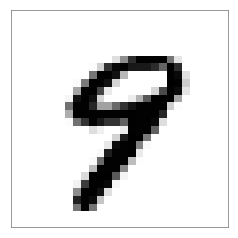

In [6]:
def show_digit(digit_array):
    plt.imshow(digit_array.cpu().numpy().reshape(num_pixels)[rev_perm_idxs].reshape(width, height), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[:,31])

# Train

Some functions to save checkpoints during training:

In [7]:
def filename(step, accuracy, loss):
    return os.path.join(CHECKPOINTFOLDER, f'step_{step}_acc={accuracy:.2f}_loss={loss:.2f}.pkl')
    
def parse_filename(filename):
    pattern = re.compile(r'(?:step_)(\d*)(?:_acc=)(\d*\.\d*)(?:_loss=)(\d*\.\d*)(?:.pkl)')
    match = pattern.findall(filename)[0]
    return int(match[0]), float(match[1]), float(match[2])

def history():
    all_filenames = sorted([parse_filename(fn) for fn in os.listdir(CHECKPOINTFOLDER)])
    return zip(*all_filenames)

def last_filename():
    steps, accuracies, losses = history()
    return filename(steps[-1], accuracies[-1], losses[-1])

def best_filename():
    steps, accuracies, losses = history()
    best_accuracy = max(accuracies)
    best_index = accuracies.index(best_accuracy)
    return filename(steps[best_index], accuracies[best_index], losses[best_index])

Create the model

In [8]:
if not os.path.isdir(CHECKPOINTFOLDER):
    os.mkdir(CHECKPOINTFOLDER)
    
start_step = -1
model = EURNN(num_inputs, num_hidden_rnn, num_labels, capacity_rnn).to(device)#.initialize()
if len(os.listdir(CHECKPOINTFOLDER))>0:
    model.load_state_dict(torch.load(last_filename()))
    start_step, _, _ = parse_filename(last_filename())
    print('model loaded')
start_step += 1

print(start_step)

model loaded
40000


We use the categorical cross entropy loss for training the model.

As optimizer we could use a Gradient Descent optimizer [with or without decaying learning rate] or one of the more sophisticated (and easier to optimize) optimizers like Adam or RMSProp

In [9]:
# loss
lossfunc = torch.nn.CrossEntropyLoss()

# accuracy
def accuracy(logits, labels):
    return 100*np.mean(np.argmax(logits.data.cpu().numpy(), 1) == labels.data.cpu().numpy())

# RMSprop Optimizer
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Start the training. This takes about 24 hours. [enable by converting the cell to a code cell]

Training history:

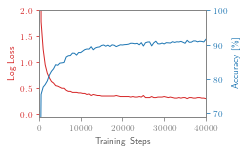

In [10]:
#from mplstyle import paper
steps, acc, loss = history()

with custom_style():
    fig, ax_loss = plt.subplots()
    ax_acc = ax_loss.twinx()

    plt.sca(ax_acc)
    plt.plot(steps, acc, '-', color='C1')
    plt.ylabel('Accuracy [\%]', color='C1');
    plt.tick_params('y', colors='C1')
    plt.ylim(69,100)
    plt.yticks([70,80,90,100])

    plt.sca(ax_loss)
    plt.plot(steps, loss, '-', color='C0')
    plt.ylabel('Log Loss', color='C0');
    plt.tick_params('y', colors='C0')
    plt.ylim(-0.05,2)

    plt.xlim(0, (max(steps)+100)//100*100)
    plt.xlabel('Training Steps')
    #plt.title('Validation Loss / Accuracy')
    plt.tight_layout()
    plt.show()

## Test

Finally, the accuracy on the test set can be evaluated:

In [11]:
model.load_state_dict(torch.load(best_filename()))
model.hidden_layer.initialize()
with torch.no_grad():
    # we need to split the calculation of the test loss in batches
    # to avoid memory problems.
    test_accuracy = np.zeros(test_size//test_batch_size)
    for i in range(0, test_size, test_batch_size):
        test_logits = model(test_values[:,i:i+test_batch_size].contiguous())
        test_accuracy[i//test_batch_size] = accuracy(test_logits, test_labels[i:i+test_batch_size]).item()
test_accuracy = test_accuracy.mean()
print(f'Test Accuracy = {test_accuracy:5.2f}')

Test Accuracy = 91.50


Visualize an example

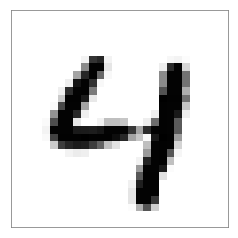

prediction=4	target=4


In [12]:
N = 318
show_digit(test_values[:,N])
test_logits = model(test_values[:,N:N+1])
prediction = torch.argmax(test_logits[0]).item()
target = test_labels[N].item()
print(f'prediction={prediction}\ttarget={target}')